In [5]:
# Misc
import os
import time
# import umap
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
# from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression as mutual_inf
# Locals
# import audio.audio_corrupts as corrupt
import audio.audio_model as audiotrain
import audio.audio_data as dataudio
# Torch
import torch
# import torchaudio
# from torch import nn
# from torch.utils.data import DataLoader

get a batch

In [6]:
DATA = "C:\\audio_dataset\\UrbanSound8K"
np.random.seed(0)
file = os.path.join(DATA, "metadata", "UrbanSound8K.csv")
df = pd.read_csv(file)
df['relative_path'] = '\\audio' + '\\fold' + df['fold'].astype(str) + '\\' + df['slice_file_name'].astype(str)
df['corrupt'] = np.random.rand(len(df))
df = df[['relative_path', 'classID', 'corrupt']]
train, val = train_test_split(df, test_size=0.2,random_state=420)
train, val = train.reset_index(drop = True), val.reset_index(drop = True) 

print(val.head())
train_ds = dataudio.SoundDS(train, DATA, transform = True)
val_ds = dataudio.SoundDS(val, DATA, transform = False)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=250, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=250, shuffle=False)

                     relative_path  classID   corrupt
0     \audio\fold5\17578-5-0-2.wav        5  0.646628
1  \audio\fold1\193698-2-0-114.wav        2  0.479139
2     \audio\fold6\66623-4-0-2.wav        4  0.367986
3      \audio\fold1\9031-3-2-0.wav        3  0.048076
4    \audio\fold7\168846-5-1-4.wav        5  0.095380


In [7]:
for i, batch in enumerate(val_dl):
    data = batch
    break

In [8]:
data[0].view(data[0].size(0), -1).size()

torch.Size([250, 22016])

model

In [9]:
def geti2l(x, layer):
    layer = layer.t()
    values = np.zeros(n, len(x)) #len(x[0])
    n = len(layer)
    for i in range(n):
        values[i] = mutual_inf(x, layer[i])
    return values

In [30]:
from concurrent.futures import ThreadPoolExecutor
iters = [1, 20, 50, 70, 100]
model = audiotrain.AudioModel()
# models = [model, model, model]
outs = []
l2o = []
for i in range(len(iters)):  
    state = torch.load(f'test\\clean\\clean_{iters[i]}.pt')
    model.load_state_dict(state["params"])
    x, y = data
    # print(y.size())
    start_time = time.time()
    out = model.encode(x, 2).detach()
    outs.append(out)
    print("Encoding: %s s" % (time.time() - start_time))
    # print(x.size())
    # print(out.t().size())
    start_time = time.time()
    layer2out = np.array(mutual_inf(out, y))
    # print(layer2out.shape)
    l2o.append(np.sum(layer2out))
    print("l2o: %s s" % (time.time() - start_time))
# print(layer2out)
pca = PCA(n_components=100)
awa = np.array(pca.fit_transform(out))

params_list = [[x, x, x, x, x], [outs[0], outs[1], outs[2], outs[3], outs[4]]]
num_threads = 5
start_time = time.time()
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    i2l = list(executor.map(geti2l, params_list[0], params_list[1]))
print(i2l)
# in2layer = geti2l(x, out)
print("i2l: %s s" % (time.time() - start_time))
# print(in2layer)


Encoding: 0.04901123046875 s
l2o: 0.8561685085296631 s
Encoding: 0.03200721740722656 s
l2o: 0.8324978351593018 s
Encoding: 0.03200554847717285 s
l2o: 0.8263163566589355 s
Encoding: 0.04600954055786133 s
l2o: 0.8114087581634521 s
Encoding: 0.0390162467956543 s
l2o: 0.8498849868774414 s
[array([4.55390234]), array([4.40440001]), array([2.4108069]), array([1.78881836]), array([1.64408302])]
i2l: 137.68247532844543 s


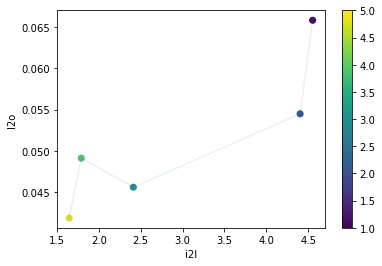

In [32]:
plt.scatter(x = i2l, y = l2o, c= [1, 2, 3, 4, 5])
plt.plot(i2l, l2o, '-o', alpha = 0.1)
plt.xlabel("i2l")
plt.ylabel("l2o")
plt.colorbar()

In [ ]:
mutual_inf(x, awa[0])

array([0.94153622, 1.05294606, 0.97443943, ..., 0.44916444, 0.47710718,
       0.4499111 ])

In [ ]:
embedding = reducer.fit_transform(awa)
print(embedding)

[[-2.2977848   3.7250195 ]
 [ 7.862205    6.166037  ]
 [ 0.30327573  7.2500834 ]
 [ 4.8211136   7.2082467 ]
 [ 8.741609    5.583044  ]
 [-2.3850393   3.3241477 ]
 [11.355143    3.2084603 ]
 [-2.1905677   4.677459  ]
 [ 2.2915103   8.498811  ]
 [ 2.0085936   8.866209  ]
 [ 5.686702    6.430809  ]
 [ 2.435308    9.338016  ]
 [ 8.348877    5.002508  ]
 [-1.3561319   4.3268456 ]
 [-3.2223773   4.9250236 ]
 [-2.3155515   4.595391  ]
 [10.7807255   2.7273734 ]
 [-0.7338241   4.5357656 ]
 [-0.02644105  6.8101993 ]
 [ 8.398214    4.64194   ]
 [ 8.538699    3.5911515 ]
 [-1.5854307   4.1935735 ]
 [-3.077206    4.585286  ]
 [-2.5547693   4.218985  ]
 [ 7.945829    6.574765  ]
 [-3.1725953   4.8285074 ]
 [ 5.748373    6.1688514 ]
 [ 7.0371504   4.566001  ]
 [ 6.6124983   6.7116947 ]
 [ 1.5131507   8.705071  ]
 [ 2.5083823   9.400297  ]
 [ 7.266891    4.4394274 ]
 [-2.3077698   4.228129  ]
 [ 7.9597178   6.334383  ]
 [-2.6820557   3.0706723 ]
 [ 5.6627235   5.297073  ]
 [ 2.420691    8.487398  ]
 